#WGAN with RF as classifier

## Importing Libraries

In [ ]:
import os
import keras
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.initializers import RandomNormal
import tensorflow.keras.backend as K
from sklearn.utils import shuffle
from sklearn.metrics import precision_score, recall_score, f1_score,\
                            accuracy_score, balanced_accuracy_score,classification_report,\
                            confusion_matrix

In [ ]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)


## EDA

In [ ]:
df=pd.read_csv('./creditcard.csv')
df=df.drop('Time',axis=1)
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V1      284807 non-null  float64
 1   V2      284807 non-null  float64
 2   V3      284807 non-null  float64
 3   V4      284807 non-null  float64
 4   V5      284807 non-null  float64
 5   V6      284807 non-null  float64
 6   V7      284807 non-null  float64
 7   V8      284807 non-null  float64
 8   V9      284807 non-null  float64
 9   V10     284807 non-null  float64
 10  V11     284807 non-null  float64
 11  V12     284807 non-null  float64
 12  V13     284807 non-null  float64
 13  V14     284807 non-null  float64
 14  V15     284807 non-null  float64
 15  V16     284807 non-null  float64
 16  V17     284807 non-null  float64
 17  V18     284807 non-null  float64
 18  V19     284807 non-null  float64
 19  V20     284807 non-null  float64
 20  V21     284807 non-null  float64
 21  V22     28

PCA Transformation: The description of the data says that all the features went through a PCA transformation (Except for time and amount).  
Scaling: Keep in mind that in order to implement a PCA transformation features need to be previously scaled.

In [ ]:
df.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [ ]:
# checking for duplicate values
print(f"Dataset has {df.duplicated().sum()} duplicate rows")
# dropping duplicate rows
df.drop_duplicates(inplace=True)

Dataset has 9144 duplicate rows


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 275663 entries, 0 to 284806
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V1      275663 non-null  float64
 1   V2      275663 non-null  float64
 2   V3      275663 non-null  float64
 3   V4      275663 non-null  float64
 4   V5      275663 non-null  float64
 5   V6      275663 non-null  float64
 6   V7      275663 non-null  float64
 7   V8      275663 non-null  float64
 8   V9      275663 non-null  float64
 9   V10     275663 non-null  float64
 10  V11     275663 non-null  float64
 11  V12     275663 non-null  float64
 12  V13     275663 non-null  float64
 13  V14     275663 non-null  float64
 14  V15     275663 non-null  float64
 15  V16     275663 non-null  float64
 16  V17     275663 non-null  float64
 17  V18     275663 non-null  float64
 18  V19     275663 non-null  float64
 19  V20     275663 non-null  float64
 20  V21     275663 non-null  float64
 21  V22     275663 

There is no null values

In [ ]:
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


<Axes: xlabel='Class', ylabel='count'>

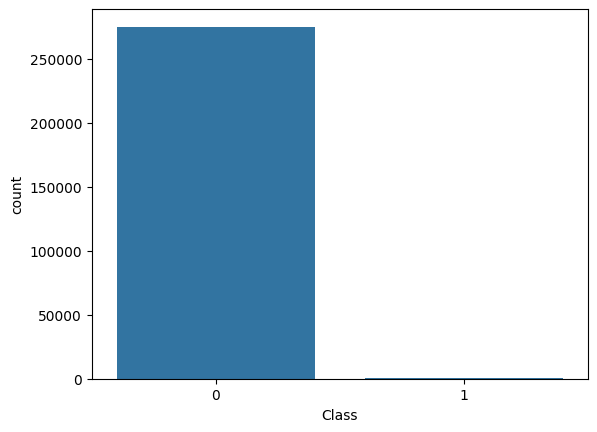

In [ ]:
sns.countplot(data=df,x='Class')

In [ ]:
df.drop('Class',axis=1).skew()

,0
V1,-3.273070
V2,-4.653486
V3,-2.216730
V4,0.681387
V5,-2.458790
V6,1.867576
V7,2.877722
V8,-8.292631
V9,0.550965
V10,1.242165


<Axes: xlabel='Amount', ylabel='Density'>

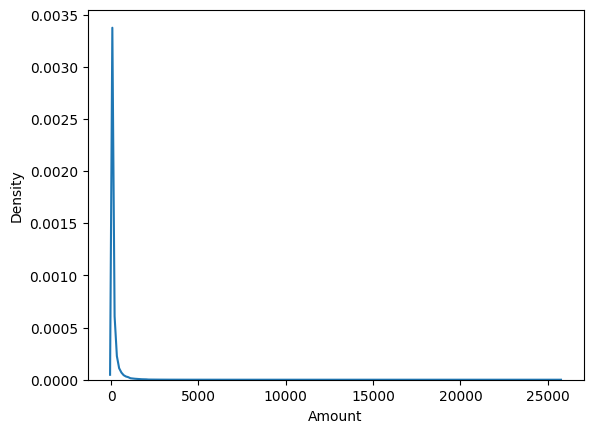

In [ ]:
sns.kdeplot(df['Amount'])

<Axes: xlabel='Amount', ylabel='Density'>

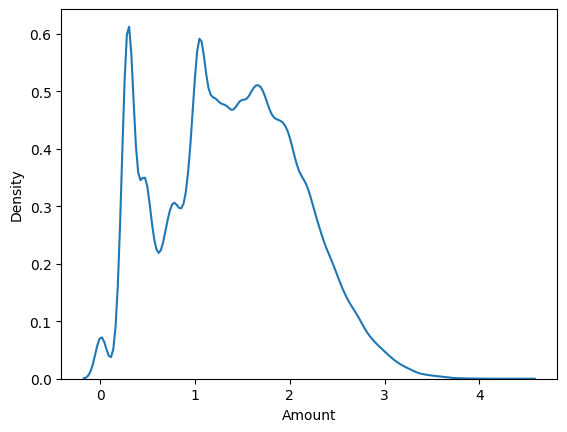

In [ ]:
df['Amount'] = df['Amount'].apply(lambda x: np.log10(x+1))
sns.kdeplot(df['Amount'])

## Creating a sub sample

What - create a[](http://) df with equal number of fraud and non fraud samples  
Why - Although we don't know what the "V" features stand for, it will be useful to understand how each of this features influence the target. By having an imbalance dataframe we are not able to see the true correlations between the class and features

In [ ]:
df = df.sample(frac=1)

fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

subsample = pd.concat([fraud_df, non_fraud_df])
new_df = subsample.sample(frac=1, random_state=42)

### Correlation

In [ ]:
corr = df.corr()
fig=px.imshow(corr, aspect="auto" ,color_continuous_scale='RdBu_r')
fig.show()

In [ ]:
corr = new_df.corr()
fig=px.imshow(corr, aspect="auto" ,color_continuous_scale='RdBu_r')
fig.show()

Negative Correlations: V17, V14, V12 and V10 are negatively correlated.  
Positive Correlations: V2, V4, V11 are positively correlated.

Note-Used chatgpt to understand the correlations. As the features are anonymised it was difficult to conclude and get relationship and dependency on eachother.

In [ ]:
# Calculate absolute correlation matrix (optional: choose df or new_df)
corr_matrix = new_df.corr().abs()

# Select upper triangle of correlation matrix to avoid duplicates and self-correlation
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Set threshold
threshold = 0.9

# Find feature pairs with high correlation
high_corr_pairs = [(col1, col2, corr_matrix.loc[col1, col2])
                   for col1 in upper.columns
                   for col2 in upper.columns
                   if (upper.loc[col1, col2] > threshold)]

# Display results
print("Highly Correlated Feature Pairs (|r| > 0.9):")
for f1, f2, corr_value in high_corr_pairs:
    print(f"{f1} ↔ {f2}: r = {corr_value:.2f}")

Highly Correlated Feature Pairs (|r| > 0.9):
V11 ↔ V12: r = 0.90
V16 ↔ V17: r = 0.95
V16 ↔ V18: r = 0.90
V17 ↔ V18: r = 0.94


### TSNE

In [ ]:
from sklearn.manifold import TSNE
X = new_df.drop('Class', axis=1)
y = new_df['Class']

# T-SNE Implementation
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)

In [ ]:
fig=px.scatter(x=X_reduced_tsne[:,0], y=X_reduced_tsne[:,1], color=y)
fig.show()

Although the subsample is pretty small, the t-SNE algorithm is able to detect clusters pretty accurately

Reference- https://www.geeksforgeeks.org/machine-learning/difference-between-pca-vs-t-sne/

Note-ChatGPT was used to help understand the results using WebSearch Feature.

## Scaling

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(df.drop('Class', axis=1))
y = df['Class'].values
print(X.shape, y.shape)

(275663, 29) (275663,)


## Splitting the data

we want to test our models on the original testing set not on the testing set created from GAN. The main goal is to fit the model in the generated data, and test it on the original testing set.

In [ ]:
# Check for and drop rows with NaN values
df.dropna(inplace=True)

X = scaler.fit_transform(df.drop('Class', axis=1))
y = df['Class'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Testing baseline model with original data

In [ ]:

def wasserstein_loss(y_true, y_pred):
      return K.mean(y_true * y_pred)

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, Flatten
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.initializers import RandomNormal
import numpy as np

class WGAN:
    def __init__(self):
        self.latent_dim = 32
        self.out_shape = 29
        self.n_critic = 5  # Train discriminator more than generator
        self.clip_value = 0.01  # weight clipping range
        self.batch_size = 64

        self.critic = self.build_critic()
        self.critic.compile(loss=wasserstein_loss,
                            optimizer=RMSprop(learning_rate=0.00005))

        self.generator = self.build_generator()

        # Combined model
        z = Input(shape=(self.latent_dim,))
        fake_sample = self.generator(z)
        self.critic.trainable = False
        valid = self.critic(fake_sample)

        self.combined = Model(z, valid)
        self.combined.compile(loss=wasserstein_loss, optimizer=RMSprop(learning_rate=0.00005))

    def build_generator(self):
        model = tf.keras.Sequential()
        model.add(Dense(128, input_dim=self.latent_dim))
        model.add(LeakyReLU(0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(0.2))
        model.add(Dense(self.out_shape, activation='tanh'))

        z = Input(shape=(self.latent_dim,))
        gen_sample = model(z)
        return Model(z, gen_sample)



    def build_critic(self):
        model = tf.keras.Sequential()
        model.add(Dense(512, input_dim=self.out_shape))
        model.add(LeakyReLU(0.2))
        model.add(Dropout(0.4))
        model.add(Dense(256))
        model.add(LeakyReLU(0.2))
        model.add(Dense(1))  # No activation

        sample = Input(shape=(self.out_shape,))
        validity = model(sample)
        return Model(sample, validity)

    def train(self, X_train, epochs=10000, batch_size=64, sample_interval=500):
        real = -np.ones((batch_size, 1))
        fake = np.ones((batch_size, 1))

        for epoch in range(epochs):
            for _ in range(self.n_critic):
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                real_samples = X_train[idx]

                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                gen_samples = self.generator.predict(noise, verbose=0)

                d_loss_real = self.critic.train_on_batch(real_samples, real)
                d_loss_fake = self.critic.train_on_batch(gen_samples, fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                # Clip weights
                for l in self.critic.layers:
                    weights = l.get_weights()
                    weights = [np.clip(w, -self.clip_value, self.clip_value) for w in weights]
                    l.set_weights(weights)

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            g_loss = self.combined.train_on_batch(noise, real)

            if (epoch + 1) % sample_interval == 0:
                print(f"{epoch+1} [D loss: {d_loss:.4f}] [G loss: {g_loss:.4f}]")


In [ ]:
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


wgan = WGAN()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [ ]:

wgan.train(X_train, epochs=1000, batch_size=64, sample_interval=100)




100 [D loss: 0.0002] [G loss: -0.0002]
200 [D loss: 0.0003] [G loss: -0.0003]
300 [D loss: 0.0003] [G loss: -0.0003]
400 [D loss: 0.0003] [G loss: -0.0004]
500 [D loss: 0.0004] [G loss: -0.0004]
600 [D loss: 0.0004] [G loss: -0.0005]
700 [D loss: 0.0004] [G loss: -0.0006]
800 [D loss: 0.0005] [G loss: -0.0006]
900 [D loss: 0.0005] [G loss: -0.0007]
1000 [D loss: 0.0005] [G loss: -0.0008]


In [ ]:

n_synth = 250_000
noise = np.random.normal(0, 1, (n_synth, wgan.latent_dim))
gen_samples = wgan.generator.predict(noise, verbose=0)


gen_samples = scaler.inverse_transform(gen_samples)
print("Synthetic shape:", gen_samples.shape)


gen_df = pd.DataFrame(gen_samples, columns=df.drop('Class', axis=1).columns)
print(gen_df.head())

# Augment training features
gen_X_train = np.vstack([X_train, gen_samples])
print("Augmented X_train shape:", gen_X_train.shape)


Synthetic shape: (250000, 29)
         V1        V2        V3        V4        V5        V6        V7  \
0  0.071196 -0.762429 -1.071847 -0.188982  0.539312 -0.618071  0.028472   
1  0.146046 -0.789078 -0.837576 -0.404383  0.660564 -0.661209  0.250026   
2 -0.008517 -0.752129 -0.994592 -0.350977  0.660258 -0.778727 -0.074672   
3 -0.170069 -0.672313 -1.103527 -0.434980  0.815784 -0.648658 -0.197980   
4 -0.460349 -0.389937 -0.847682 -0.355049  0.610226 -0.525417  0.135129   

         V8        V9       V10  ...       V20       V21       V22       V23  \
0  0.780195  0.464223  0.002938  ...  0.271266 -0.318017 -0.482257 -0.306420   
1  0.844029  0.517348  0.091894  ...  0.239338 -0.401376 -0.636748 -0.210285   
2  0.824036  0.639075  0.115904  ...  0.162997 -0.441568 -0.564290 -0.367985   
3  0.770695  0.520502  0.265997  ...  0.380523 -0.307908 -0.561709 -0.426210   
4  0.431849  0.389110  0.121235  ...  0.126677 -0.282905 -0.546076 -0.312228   

        V24       V25       V26       

In [ ]:
# 7) Augment training labels: Generated fraud data → label 1
gen_y = np.ones((n_synth, 1), dtype='int32')
y_train = y_train.reshape(-1, 1)  # Ensure y_train has shape (n, 1)
gen_y_train = np.vstack([y_train, gen_y])
print("Augmented y_train shape:", gen_y_train.shape)


Augmented y_train shape: (470530, 1)


## Evaluating the model

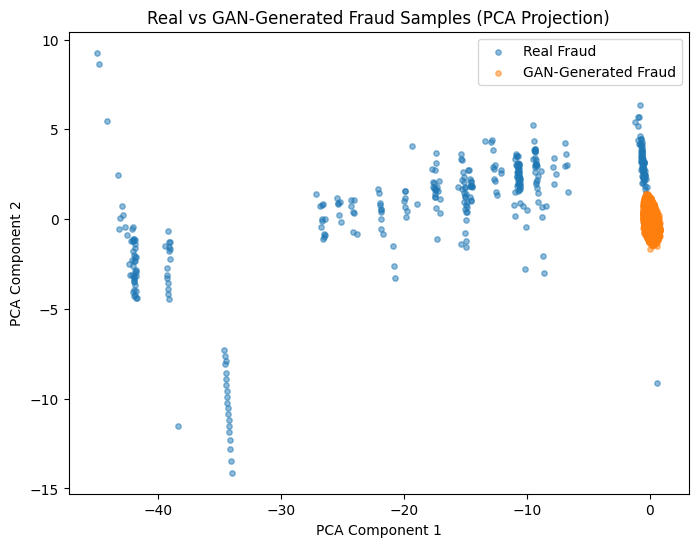

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


real_fraud = X_train[y_train.ravel() == 1]


combined_data = np.vstack([real_fraud, gen_samples])
labels = np.array([0] * len(real_fraud) + [1] * len(gen_samples))  # 0=Real, 1=Generated


pca = PCA(n_components=2, random_state=42)
proj = pca.fit_transform(combined_data)


plt.figure(figsize=(8,6))
plt.scatter(proj[labels==0, 0], proj[labels==0, 1],
            alpha=0.5, label='Real Fraud', s=15)
plt.scatter(proj[labels==1, 0], proj[labels==1, 1],
            alpha=0.5, label='GAN-Generated Fraud', s=15)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Real vs GAN-Generated Fraud Samples (PCA Projection)")
plt.legend()
plt.show()


WGAN generated fraud samples cluster too narrowly, suggesting limited representation of fraud space. Although this can still help classifiers learn some fraud patterns, it risks overfitting to synthetic samples and missing diverse real frauds.

Note- ChatGPT used for understanding results and how discriminator can be used.

Reference-https://medium.com/the-research-nest/exploring-gans-to-generate-synthetic-data-ca48f8a4b518

ROC-AUC: 0.9529
PR-AUC:  0.8454

Classification Report:
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     55038
           1     0.9589    0.7368    0.8333        95

    accuracy                         0.9995     55133
   macro avg     0.9792    0.8684    0.9165     55133
weighted avg     0.9995    0.9995    0.9995     55133



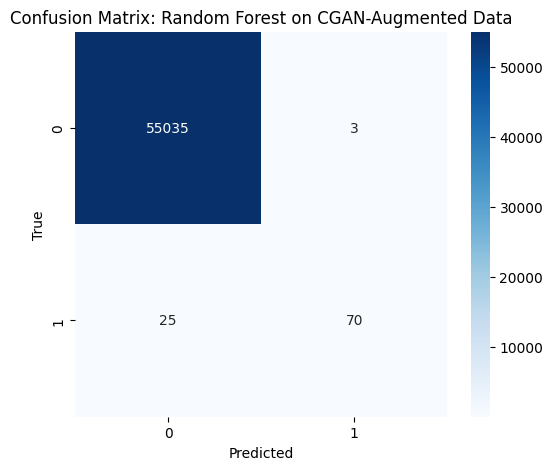

In [ ]:

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score
)
import matplotlib.pyplot as plt
import seaborn as sns


gen_y_train = gen_y_train.ravel()


rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf.fit(gen_X_train, gen_y_train)

# predict & probability scores on hold-out
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:,1]


roc  = roc_auc_score(y_test, y_prob)
pr   = average_precision_score(y_test, y_prob)

print(f"ROC-AUC: {roc:.4f}")
print(f"PR-AUC:  {pr:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix: Random Forest on CGAN-Augmented Data")
plt.show()

WGAN augmentation with Random Forest yields strong fraud detection performance.

The very high precision means it rarely mislabels legitimate transactions as fraud (reduces costly false positives).

Recall is solid but not perfect → some fraud cases remain undetected, showing that WGAN-generated samples improve coverage but may not capture all fraud distribution complexities.

This setup is highly practical: robust ROC-AUC and PR-AUC confirm it balances real-world needs (minimizing false alerts while detecting most fraud).

Referneces-[A hybrid deep learning approach with generative adversarial network for credit card fraud detection](https://doi.org/10.3390/technologies12100186), [Improving detection of credit card fraudulent transactions using generative adversarial networks](https://arxiv.org/abs/1907.03355),https://www.kaggle.com/code/shiratorizawa/wcgan, https://www.kaggle.com/code/gauravduttakiit/cc-fraud-detection-gan-random-forest-classifier/

Note- ChatGPT used for understanding results .